# ĐỒ ÁN MÔN HỌC HỌC MÁY -CS 114
GVHD: ThS. Cáp Phạm Đình Thăng
Lớp: LT.K2025.2
Nhóm: 13
## Phân tích và dự đoán chất lượng rượu vang (Wine Quality – UCI)

**Dataset:** Wine Quality (UCI Machine Learning Repository)  
**Link:** https://archive.ics.uci.edu/dataset/186/wine+quality

---


### EDA
- info/describe, missing
- 11 histogram features
- correlation heatmap
- quality distribution + label distribution
- nhận xét đặc trưng ảnh hưởng

### Preprocessing
- missing explicit (SimpleImputer)
- outliers explicit (IQR clipping) leak-free
- scaling Standard/MinMax
- split test_size 0.1/0.2/0.3 loop
- label: 0 (≤5), 1 (≥6)

### Models
- Logistic Regression, Decision Tree, LightGBM, XGBoost

### Evaluation
- Accuracy, Precision, Recall, F1
- Confusion matrix
- ROC curve + AUC
- bảng so sánh mô hình

### Feature importance
- LGBM + XGBoost

## Optional
- Train  Red vs White
- Regression (RMSE/MAE/R2)
- Cross-validation mean±std
- Tuning (RandomizedSearchCV)


## 1) Import & cấu hình





- Import các thư viện cần thiết cho EDA, preprocessing, modeling và evaluation.
- Thiết lập các tham số dùng xuyên suốt:
  - `TEST_SIZES = (0.1, 0.2, 0.3)` theo yêu cầu đề.
  - Quy tắc nhị phân hóa: **0 nếu quality ≤ 5**, **1 nếu quality ≥ 6**.
  - Chọn scaler: **StandardScaler** hoặc **MinMaxScaler** để so sánh.


In [2]:

# !pip -q install lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    mean_squared_error, mean_absolute_error, r2_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
TEST_SIZES = (0.1, 0.2, 0.3)
LABEL_THRESHOLD = 6                # label=1 nếu quality>=6
SCALER_MODE = "standard"           # "standard" hoặc "minmax"
CV_FOLDS = 5                       # optional: 5-fold
IQR_FACTOR = 1.5                   # outlier clipping


## 2)Load dataset


In [3]:
import os, urllib.request

base = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
files = {
    "winequality-red.csv": base + "winequality-red.csv",
    "winequality-white.csv": base + "winequality-white.csv",
}

for fn, url in files.items():
    if not os.path.exists(fn):
        print("Downloading:", fn)
        urllib.request.urlretrieve(url, fn)

print("Files present:", [fn for fn in files if os.path.exists(fn)])


Downloading: winequality-red.csv
Downloading: winequality-white.csv
Files present: ['winequality-red.csv', 'winequality-white.csv']


## 3) Data Ingestion: đọc đỏ + trắng, concat, thêm wine_type


Thu thập & tích hợp dữ liệu

Dataset gồm 2 phần:
- **Red wine**: ~1599 mẫu
- **White wine**: ~4898 mẫu  
Mỗi mẫu có **11 đặc trưng hóa học** và nhãn `quality` (điểm chất lượng).

Trong notebook:
- Đọc 2 file CSV (phân tách bằng dấu `;`).
- Thêm biến `wine_type` để phân biệt đỏ/trắng.
- Hợp nhất (concatenate) thành một bảng dữ liệu tổng.


In [4]:
RED_PATH = "winequality-red.csv"
WHITE_PATH = "winequality-white.csv"
sep = ";"

df_red = pd.read_csv(RED_PATH, sep=sep)
df_white = pd.read_csv(WHITE_PATH, sep=sep)

df_red["wine_type"] = "red"
df_white["wine_type"] = "white"

df = pd.concat([df_red, df_white], ignore_index=True)
print("Shape:", df.shape)
df.head()


Shape: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## 4) EDA: info/describe + missing values





- Xem cấu trúc dữ liệu (`info()`), thống kê mô tả (`describe()`).
- Kiểm tra giá trị thiếu (missing values).  
Dù dataset UCI thường sạch, ta vẫn kiểm tra để:
- đảm bảo báo cáo đúng yêu cầu đề,
- chuẩn bị cho pipeline tổng quát khi triển khai trên dữ liệu thực tế.


In [5]:
display(df.info())
display(df.describe())

missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])
print("Total missing:", int(missing.sum()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


,0


Total missing: 0


## 5) EDA: phân bố quality + nhãn nhị phân (0:<=5, 1:>=6)


Phân bố nhãn quality & chuyển sang bài toán phân loại nhị phân

Vì đề cho phép phân loại cao/thấp, ta chuyển `quality` thành nhãn nhị phân:
- **label = 0 (thấp)** nếu `quality ≤ 5`
- **label = 1 (cao)** nếu `quality ≥ 6`

Phần này gồm:
- Histogram phân bố `quality`
- Biểu đồ phân bố `label` để kiểm tra **mất cân bằng lớp (class imbalance)**


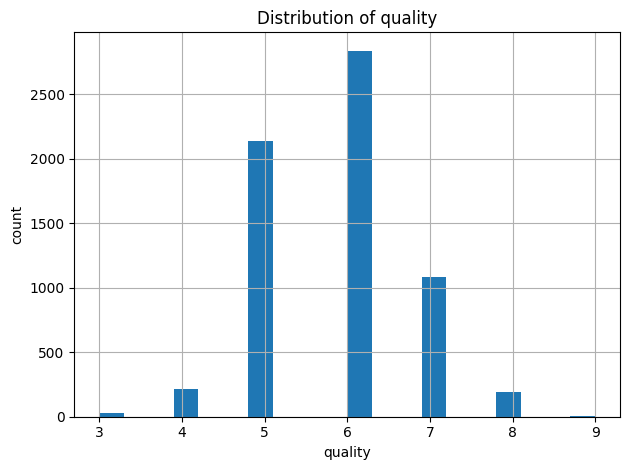

,proportion
label,
1,0.633061
0,0.366939


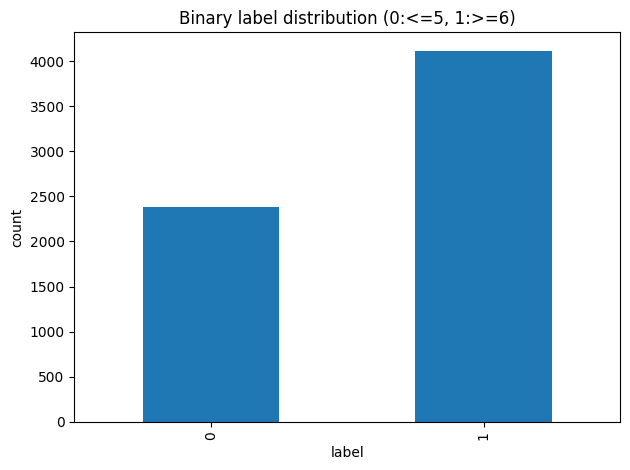

In [35]:
plt.figure()
df["quality"].hist(bins=20)
plt.title("Distribution of quality")
plt.xlabel("quality"); plt.ylabel("count")
plt.tight_layout()
plt.show()

df["label"] = (df["quality"] >= LABEL_THRESHOLD).astype(int)
display(df["label"].value_counts(normalize=True).rename("proportion"))

plt.figure()
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Binary label distribution (0:<=5, 1:>=6)")
plt.xlabel("label"); plt.ylabel("count")
plt.tight_layout()
plt.show()


## 6) EDA: Phân bố từng đặc trưng (11 histogram)




Quan sát phân bố của từng feature:
- Giúp hiểu thang đo, độ lệch (skew), và các vùng giá trị phổ biến
- Hỗ trợ quyết định preprocessing như scaling/outlier handling
- Vẽ 11 histogram (gộp dạng subplot 3×4 hoặc 4×3) để tiết kiệm trang.


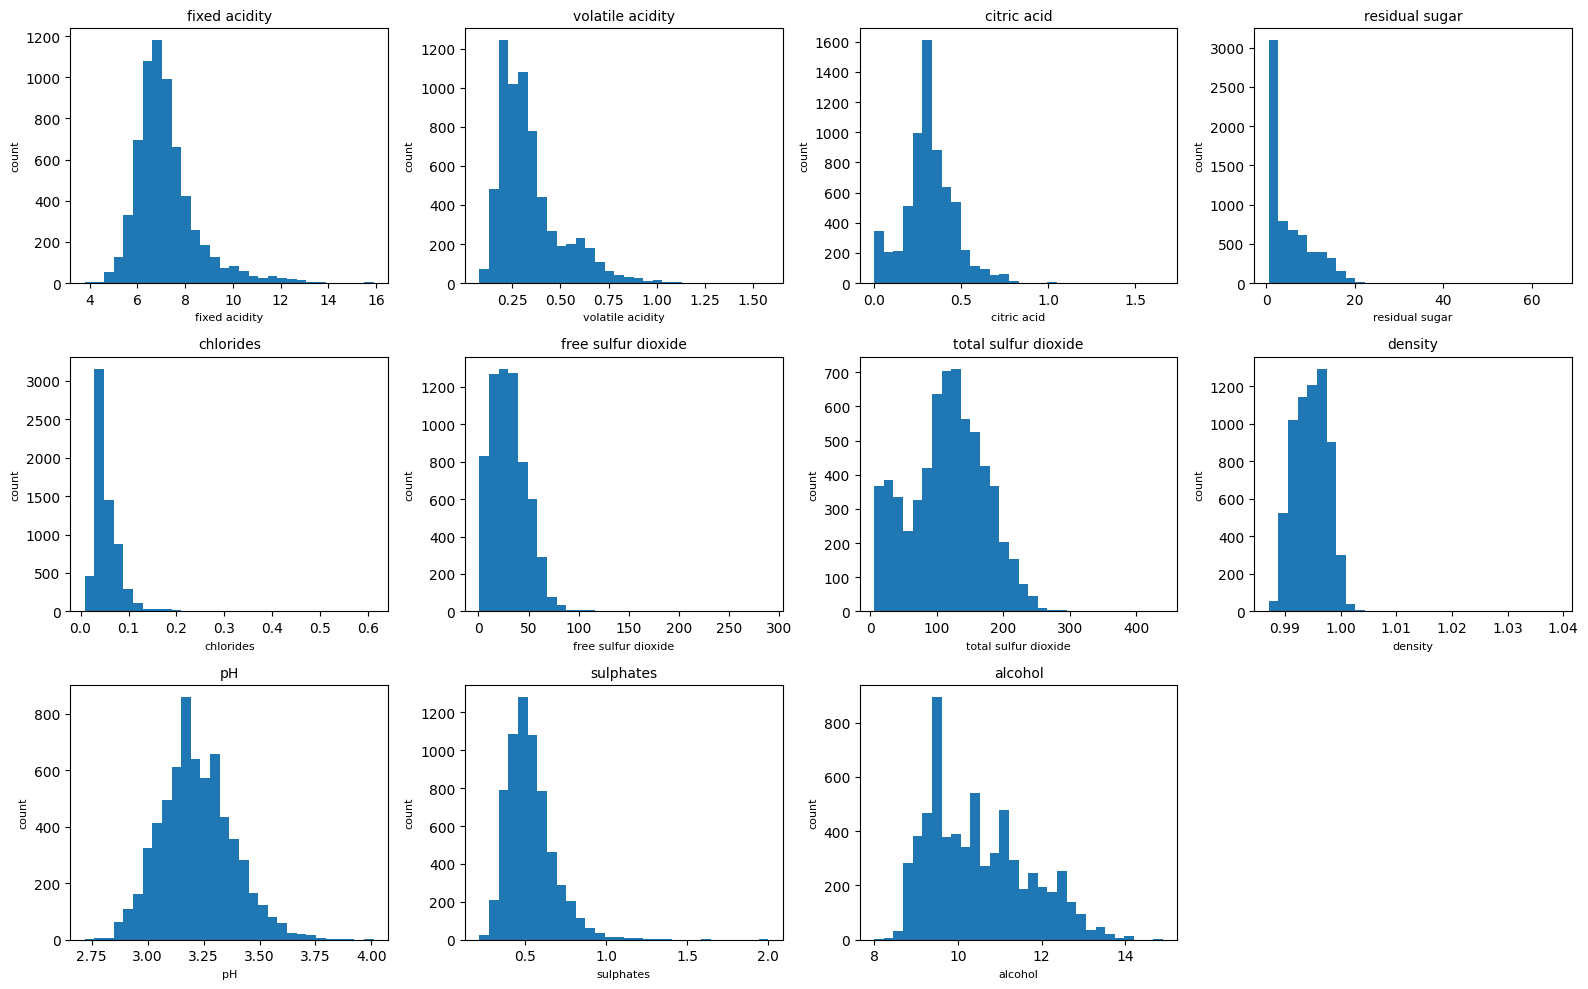

In [7]:
feature_cols = [c for c in df.columns if c not in ["quality","label","wine_type"]]

cols = 4
rows = int(np.ceil(len(feature_cols)/cols))
plt.figure(figsize=(16, 10))

for i, col in enumerate(feature_cols, 1):
    plt.subplot(rows, cols, i)
    plt.hist(df[col].dropna(), bins=30)
    plt.title(col, fontsize=10)
    plt.xlabel(col, fontsize=8)
    plt.ylabel("count", fontsize=8)

plt.tight_layout()
plt.show()


## 7) EDA: Correlation heatmap


 Tương quan giữa các đặc trưng
- Phát hiện feature tương quan cao (đa cộng tuyến) như `density` và `residual sugar`…
- Gợi ý feature nào có thể ảnh hưởng tới `quality` gián tiếp
- Hỗ trợ phần “nhận xét feature quan trọng” trong báo cáo
- Vẽ heatmap correlation trên các cột số.


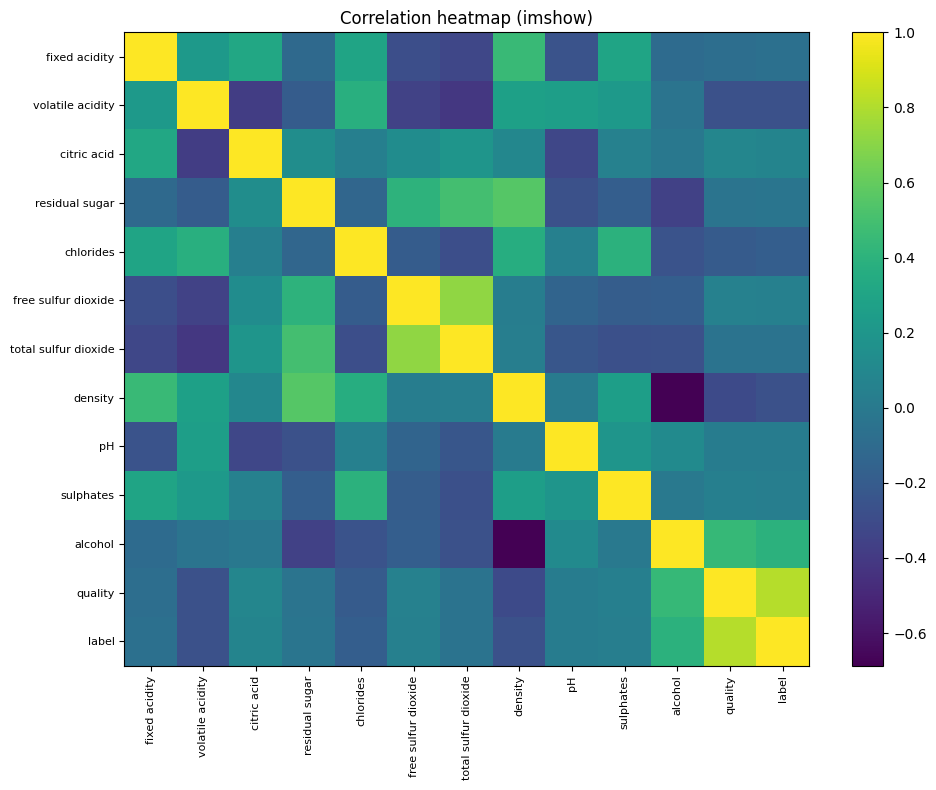

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.title("Correlation heatmap (imshow)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.index)), corr.index, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()


## 8) EDA: Outliers minh hoạ


Outliers (giá trị ngoại lai) – Minh hoạ trước xử lý

Đề yêu cầu “Loại bỏ outliers (nếu hợp lý)”.  
Trong thực tế, outliers có thể là:
- lỗi đo đạc / dữ liệu nhiễu
- hoặc giá trị thật (hợp lệ nhưng hiếm)
**không xoá mẫu** mà dùng phương án mềm:
- minh hoạ bằng **boxplot trước xử lý**
- sau đó dùng **IQR clipping** để giảm ảnh hưởng ngoại lai nhưng vẫn giữ dữ liệu.


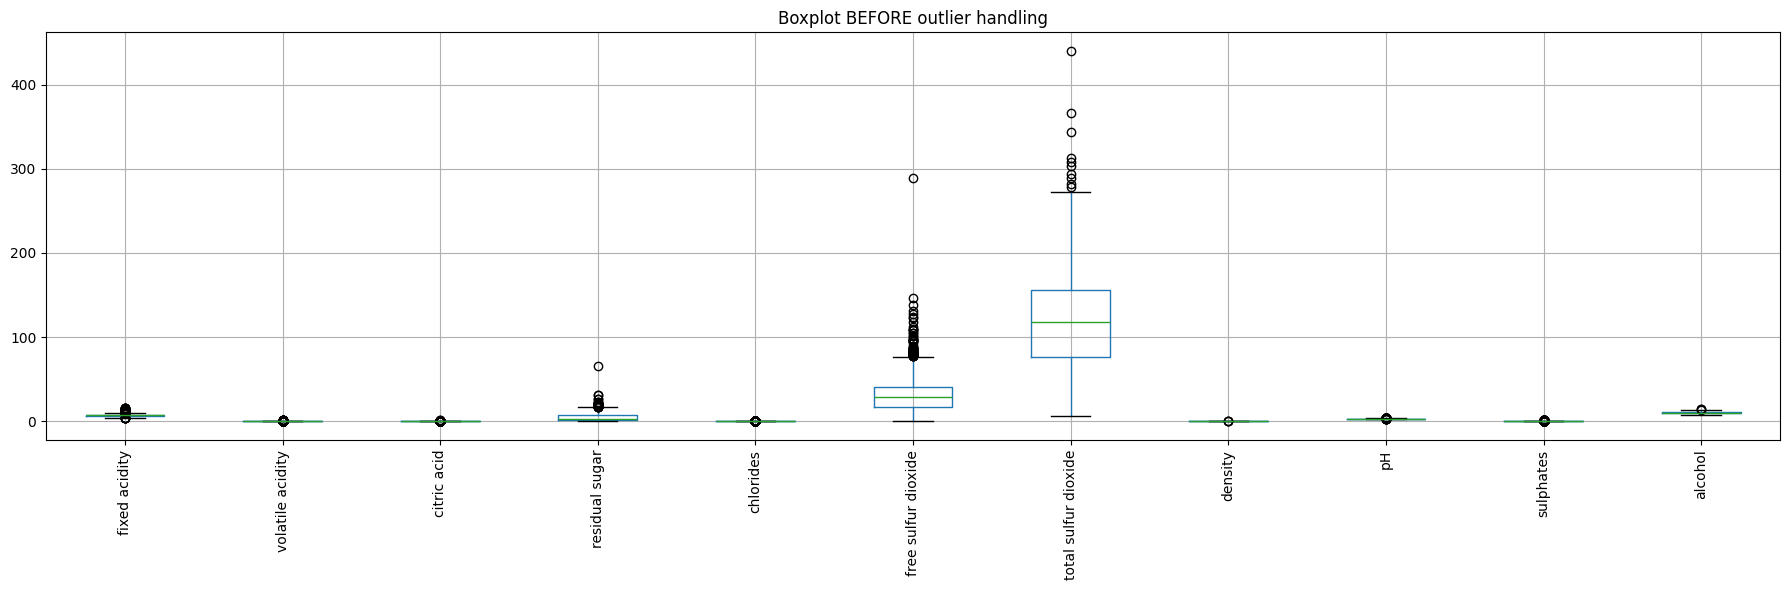

In [9]:
plt.figure(figsize=(18, 6))
df[feature_cols].boxplot(rot=90)
plt.title("Boxplot BEFORE outlier handling")
plt.tight_layout()
plt.show()


## 9) Preprocessing leak-free: Imputer + IQR clipping + Scaler + OneHot



- Dữ liệu UCI thường “sạch”, tuy nhiên vẫn dùng **SimpleImputer** để pipeline ổn định khi triển khai thực tế.
- Outlier: dùng **IQR clipping** để giảm ảnh hưởng ngoại lai nhưng **không loại bỏ mẫu**.
- Chuẩn hóa: thử **StandardScaler** (mặc định) và **MinMaxScaler** để so sánh.
- Tất cả bước preprocessing nằm trong **Pipeline/ColumnTransformer** để tránh data leakage (fit chỉ trên train).


In [10]:
class IQRClipper(BaseEstimator, TransformerMixin):
    """Clip outliers theo IQR (không drop mẫu), leak-free khi nằm trong Pipeline."""
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q1_ = np.nanpercentile(X, 25, axis=0)
        self.q3_ = np.nanpercentile(X, 75, axis=0)
        self.iqr_ = self.q3_ - self.q1_
        self.lower_ = self.q1_ - self.factor * self.iqr_
        self.upper_ = self.q3_ + self.factor * self.iqr_
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.lower_, self.upper_)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return np.array(input_features, dtype=object)


def make_preprocess(X: pd.DataFrame):
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    scaler = StandardScaler() if SCALER_MODE == "standard" else MinMaxScaler()

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("iqr", IQRClipper(factor=IQR_FACTOR)),
        ("scaler", scaler),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_features),
            ("cat", cat_pipe, categorical_features),
        ],
        remainder="drop"
    )
    return preprocess


## 10) 4 mô hình ML (LogReg, DecisionTree, LGBM, XGBoost)


Xây dựng mô hình Machine Learning
1) **Logistic Regression** (baseline)  
2) **Decision Tree**  
3) **LightGBM**  
4) **XGBoost**

Để so sánh :
- Mỗi mô hình dùng cùng một preprocessing pipeline.
- Nếu có mất cân bằng lớp, ưu tiên metric F1/AUC và có thể dùng `class_weight="balanced"` (với Logistic/Tree).


In [11]:
def build_models(preprocess):
    models = {}

    models["LogReg"] = Pipeline([
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ])

    models["DecisionTree"] = Pipeline([
        ("preprocess", preprocess),
        ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE))
    ])

    from lightgbm import LGBMClassifier
    models["LGBM"] = Pipeline([
        ("preprocess", preprocess),
        ("clf", LGBMClassifier(
            n_estimators=400, learning_rate=0.05,
            random_state=RANDOM_STATE,
            is_unbalance=True
        ))
    ])

    from xgboost import XGBClassifier
    models["XGBoost"] = Pipeline([
        ("preprocess", preprocess),
        ("clf", XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.9,
            eval_metric="logloss",
            random_state=RANDOM_STATE
        ))
    ])

    return models


## 11) Đánh giá chung: Acc/Prec/Rec/F1 + Confusion Matrix + ROC-AUC


### Đánh giá mô hình
- Sử dụng: Accuracy, Precision, Recall, F1-score.
- Trực quan: Confusion Matrix.
- Với bài toán nhị phân: ROC Curve & AUC.
- Do phân bố lớp có thể lệch, ưu tiên **F1/AUC** hơn chỉ Accuracy.


In [32]:

def get_scores_for_roc(model, X_test):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_test)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X_test)
        return (s - s.min()) / (s.max() - s.min() + 1e-9)
    return model.predict(X_test)

def plot_confusion(cm, title):
    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_roc(fpr, tpr, auc_score, title):
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.title(f"{title} (AUC={auc_score:.4f})")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

def evaluate_one(name, model, X_train, X_test, y_train, y_test, plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    scores = get_scores_for_roc(model, X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_score = auc(fpr, tpr)

    if plot:
        print(f"\n=== {name} ===")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(classification_report(y_test, y_pred, zero_division=0))

        cm = confusion_matrix(y_test, y_pred)
        plot_confusion(cm, f"Confusion Matrix - {name}")
        plot_roc(fpr, tpr, auc_score, f"ROC Curve - {name}")

    return {"model": name, "acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_score}


## 12) Chạy theo nhiều tỉ lệ train/test (0.1, 0.2, 0.3) + bảng so sánh


Train/Test Split theo nhiều tỷ lệ (0.1, 0.2, 0.3)

Theo đề, ta thử nhiều tỷ lệ test:
- 90/10, 80/20, 70/30

Mục tiêu:
- xem mô hình ổn định thế nào khi test set tăng lên
- kiểm tra độ nhạy với cách chia dữ liệu

Lưu ý:
- Dùng `stratify=y` để giữ tỉ lệ lớp giống nhau giữa train/test.
- Tổng hợp kết quả thành bảng để so sánh mô hình.




==================== test_size=0.1 ====================

=== LogReg_ts0.1 ===
Accuracy : 0.7031
Precision: 0.8114
Recall   : 0.6910
F1-score : 0.7464
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       239
           1       0.81      0.69      0.75       411

    accuracy                           0.70       650
   macro avg       0.69      0.71      0.69       650
weighted avg       0.73      0.70      0.71       650



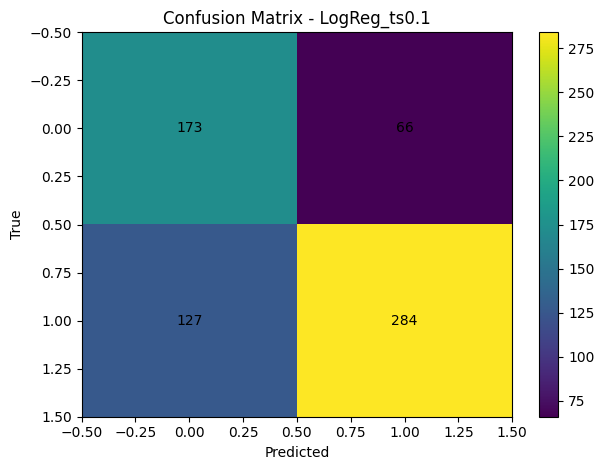

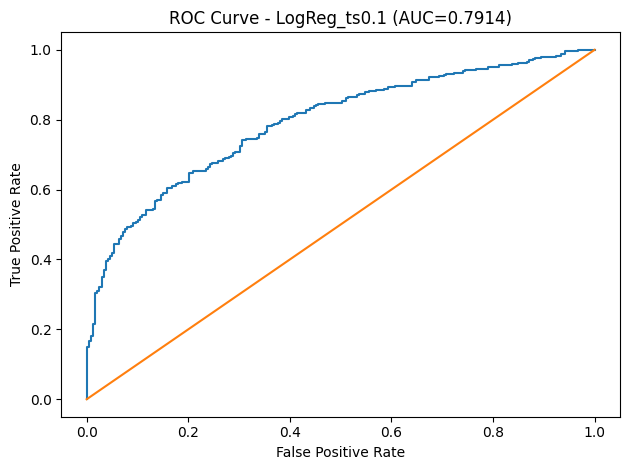


=== DecisionTree_ts0.1 ===
Accuracy : 0.7800
Precision: 0.8221
Recall   : 0.8321
F1-score : 0.8271
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       239
           1       0.82      0.83      0.83       411

    accuracy                           0.78       650
   macro avg       0.76      0.76      0.76       650
weighted avg       0.78      0.78      0.78       650



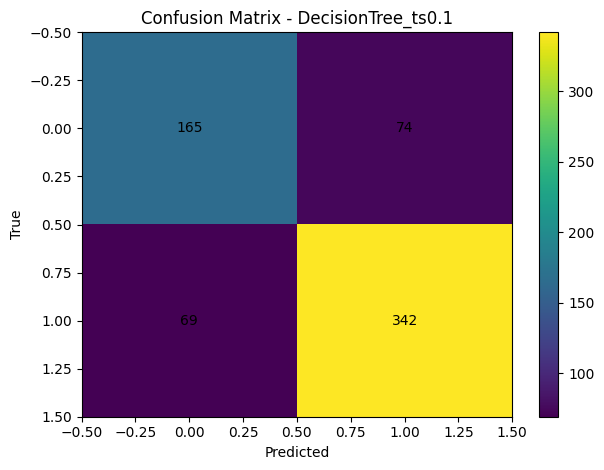

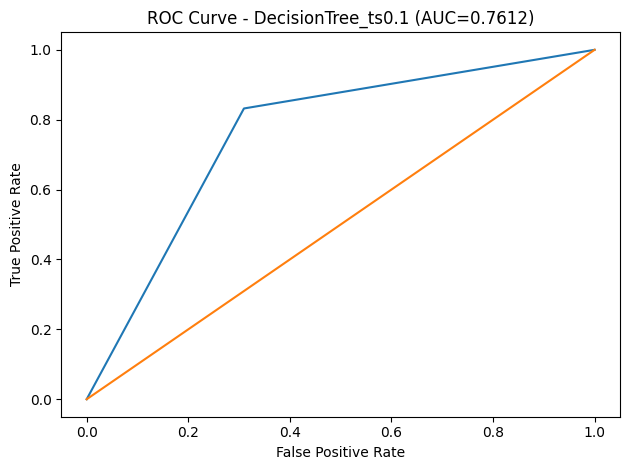

[LightGBM] [Info] Number of positive: 3702, number of negative: 2145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 5847, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633145 -> initscore=0.545734
[LightGBM] [Info] Start training from score 0.545734


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LGBM_ts0.1 ===
Accuracy : 0.8138
Precision: 0.8662
Recall   : 0.8345
F1-score : 0.8501
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       239
           1       0.87      0.83      0.85       411

    accuracy                           0.81       650
   macro avg       0.80      0.81      0.80       650
weighted avg       0.82      0.81      0.81       650



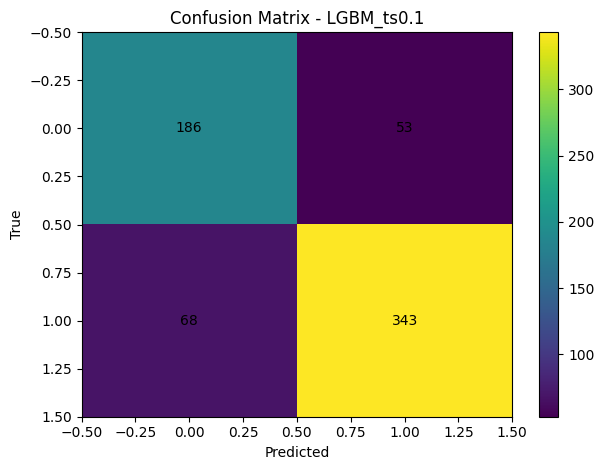

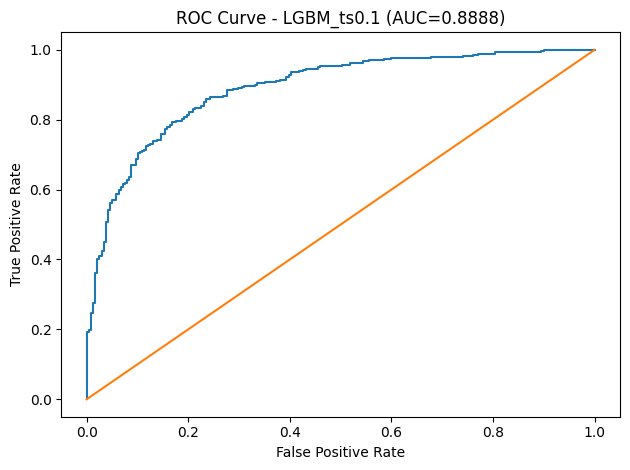


=== XGBoost_ts0.1 ===
Accuracy : 0.7908
Precision: 0.8176
Recall   : 0.8613
F1-score : 0.8389
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       239
           1       0.82      0.86      0.84       411

    accuracy                           0.79       650
   macro avg       0.78      0.77      0.77       650
weighted avg       0.79      0.79      0.79       650



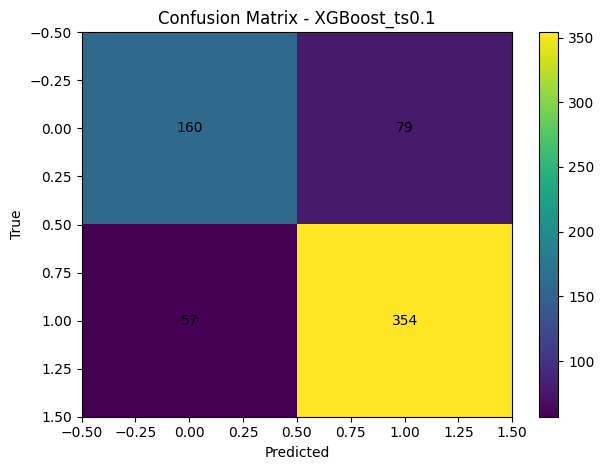

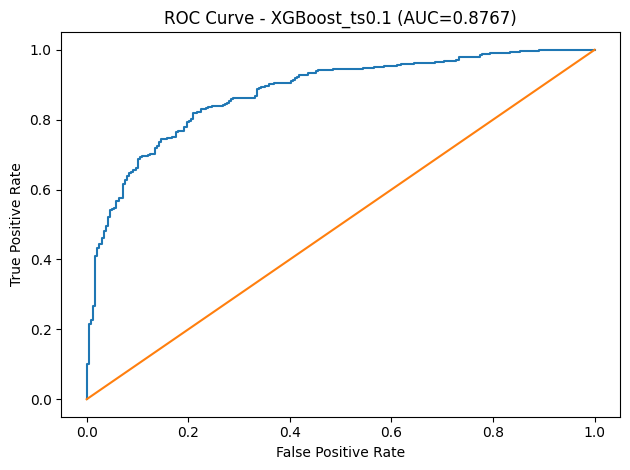



==================== test_size=0.2 ====================

=== LogReg_ts0.2 ===
Accuracy : 0.7292
Precision: 0.8239
Recall   : 0.7278
F1-score : 0.7729
              precision    recall  f1-score   support

           0       0.61      0.73      0.66       477
           1       0.82      0.73      0.77       823

    accuracy                           0.73      1300
   macro avg       0.72      0.73      0.72      1300
weighted avg       0.75      0.73      0.73      1300



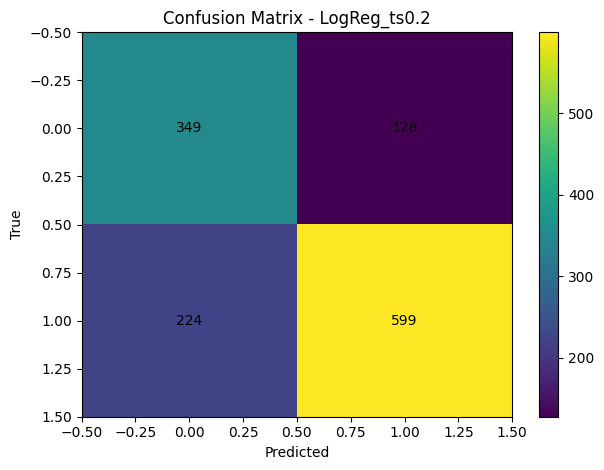

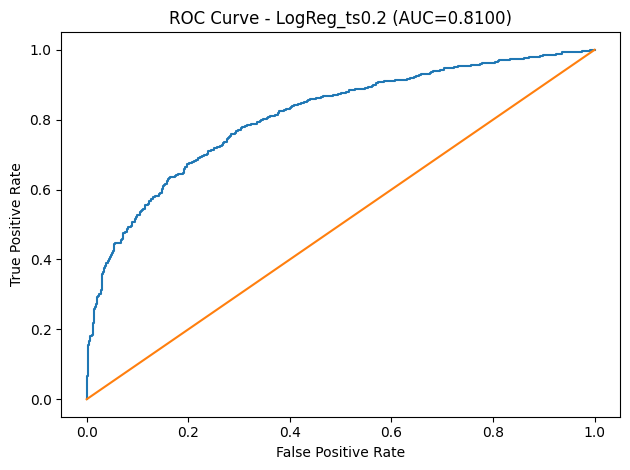


=== DecisionTree_ts0.2 ===
Accuracy : 0.7754
Precision: 0.8266
Recall   : 0.8165
F1-score : 0.8215
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       477
           1       0.83      0.82      0.82       823

    accuracy                           0.78      1300
   macro avg       0.76      0.76      0.76      1300
weighted avg       0.78      0.78      0.78      1300



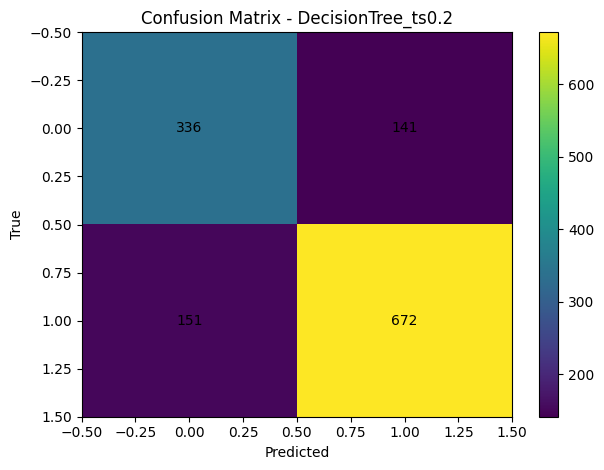

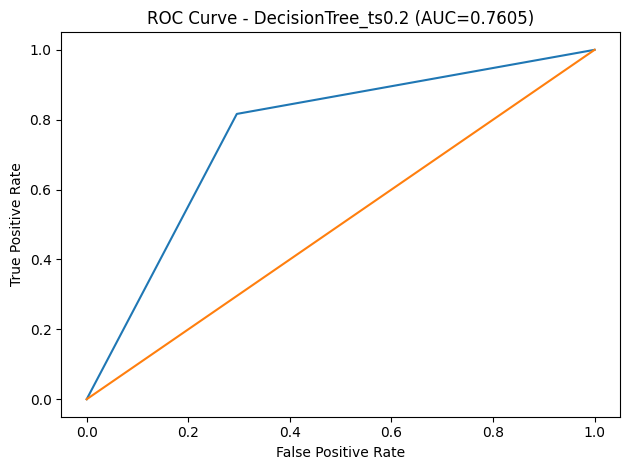

[LightGBM] [Info] Number of positive: 3290, number of negative: 1907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633058 -> initscore=0.545356
[LightGBM] [Info] Start training from score 0.545356


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LGBM_ts0.2 ===
Accuracy : 0.8146
Precision: 0.8684
Recall   : 0.8335
F1-score : 0.8506
              precision    recall  f1-score   support

           0       0.73      0.78      0.76       477
           1       0.87      0.83      0.85       823

    accuracy                           0.81      1300
   macro avg       0.80      0.81      0.80      1300
weighted avg       0.82      0.81      0.82      1300



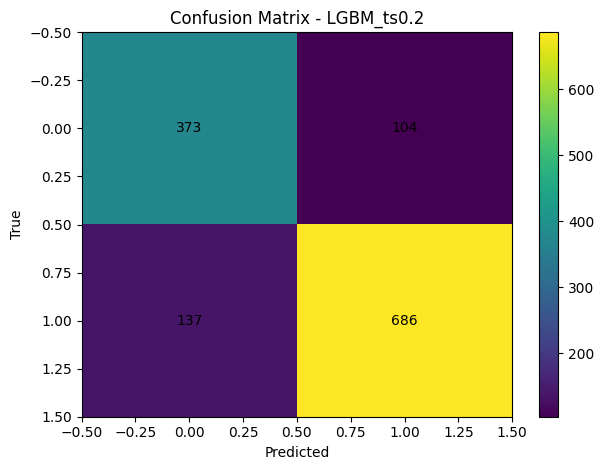

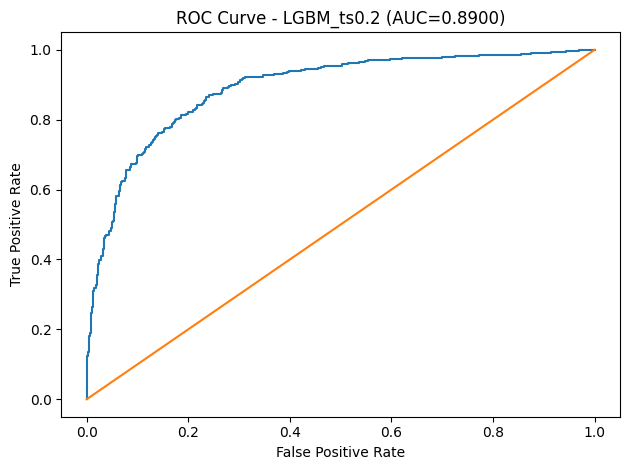


=== XGBoost_ts0.2 ===
Accuracy : 0.8200
Precision: 0.8405
Recall   : 0.8834
F1-score : 0.8614
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       477
           1       0.84      0.88      0.86       823

    accuracy                           0.82      1300
   macro avg       0.81      0.80      0.80      1300
weighted avg       0.82      0.82      0.82      1300



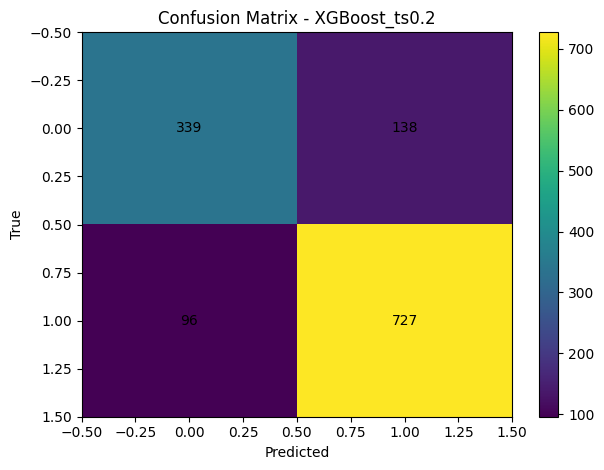

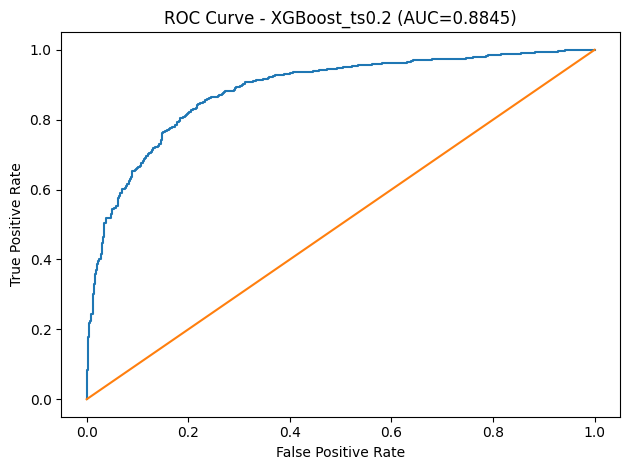



==================== test_size=0.3 ====================

=== LogReg_ts0.3 ===
Accuracy : 0.7344
Precision: 0.8266
Recall   : 0.7342
F1-score : 0.7777
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       716
           1       0.83      0.73      0.78      1234

    accuracy                           0.73      1950
   macro avg       0.72      0.73      0.72      1950
weighted avg       0.75      0.73      0.74      1950



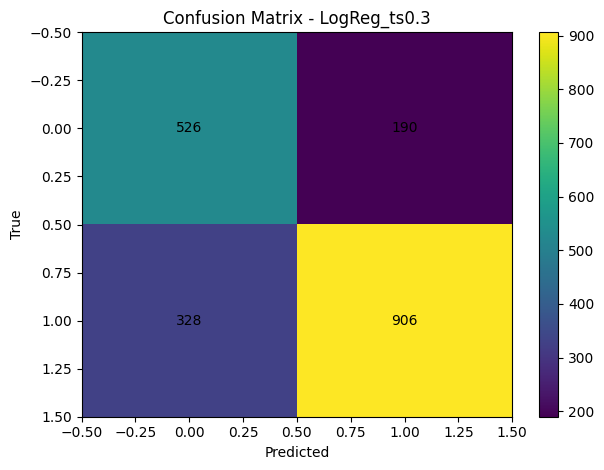

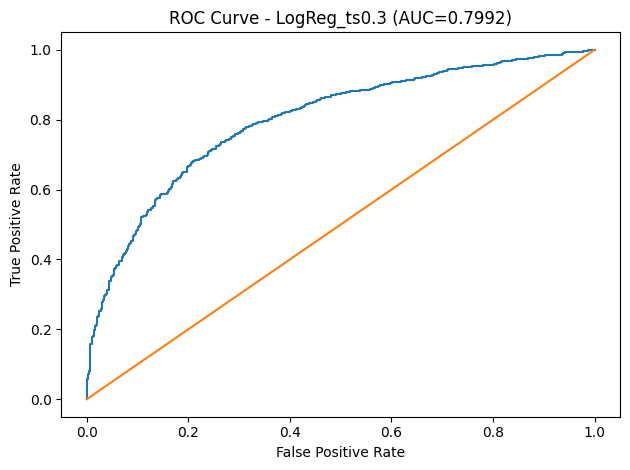


=== DecisionTree_ts0.3 ===
Accuracy : 0.7687
Precision: 0.8140
Recall   : 0.8225
F1-score : 0.8182
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       716
           1       0.81      0.82      0.82      1234

    accuracy                           0.77      1950
   macro avg       0.75      0.75      0.75      1950
weighted avg       0.77      0.77      0.77      1950



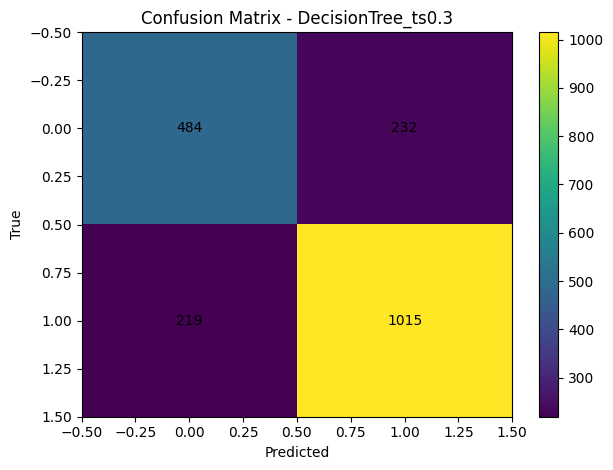

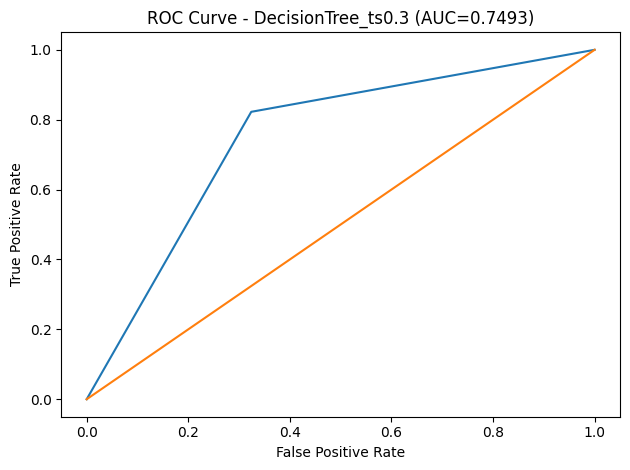

[LightGBM] [Info] Number of positive: 2879, number of negative: 1668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1271
[LightGBM] [Info] Number of data points in the train set: 4547, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633165 -> initscore=0.545818
[LightGBM] [Info] Start training from score 0.545818


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LGBM_ts0.3 ===
Accuracy : 0.8067
Precision: 0.8562
Recall   : 0.8347
F1-score : 0.8453
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       716
           1       0.86      0.83      0.85      1234

    accuracy                           0.81      1950
   macro avg       0.79      0.80      0.79      1950
weighted avg       0.81      0.81      0.81      1950



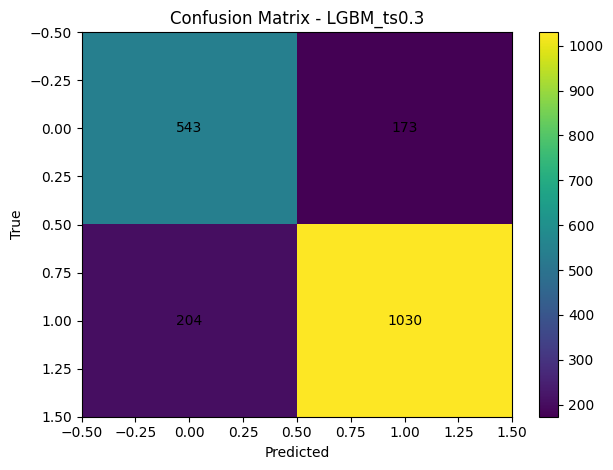

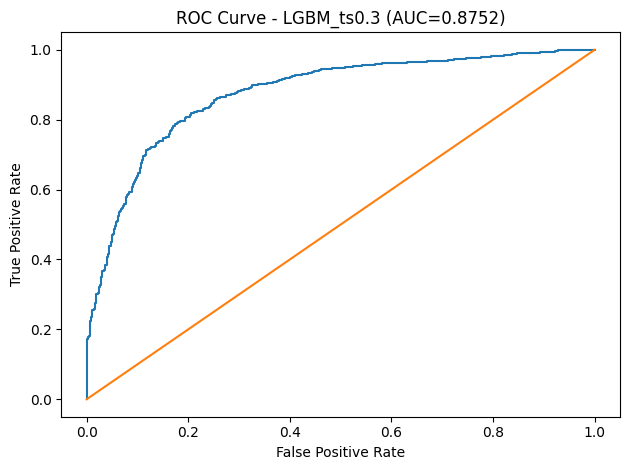


=== XGBoost_ts0.3 ===
Accuracy : 0.8133
Precision: 0.8341
Recall   : 0.8801
F1-score : 0.8565
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       716
           1       0.83      0.88      0.86      1234

    accuracy                           0.81      1950
   macro avg       0.80      0.79      0.79      1950
weighted avg       0.81      0.81      0.81      1950



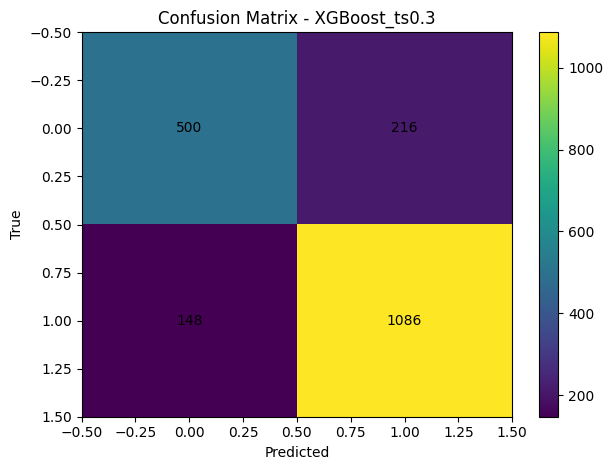

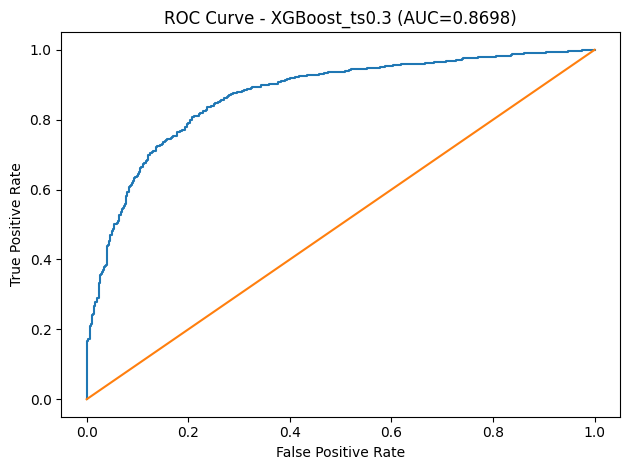

,model,acc,prec,rec,f1,auc,test_size,base_model
2,LGBM_ts0.1,0.813846,0.866162,0.834550,0.850062,0.888841,0.1,LGBM
3,XGBoost_ts0.1,0.790769,0.817552,0.861314,0.838863,0.876676,0.1,XGBoost
0,LogReg_ts0.1,0.703077,0.811429,0.690998,0.746386,0.791355,0.1,LogReg
1,DecisionTree_ts0.1,0.780000,0.822115,0.832117,0.827086,0.761247,0.1,DecisionTree
6,LGBM_ts0.2,0.814615,0.868354,0.833536,0.850589,0.889974,0.2,LGBM
7,XGBoost_ts0.2,0.820000,0.840462,0.883354,0.861374,0.884515,0.2,XGBoost
4,LogReg_ts0.2,0.729231,0.823934,0.727825,0.772903,0.810034,0.2,LogReg
5,DecisionTree_ts0.2,0.775385,0.826568,0.816525,0.821516,0.760464,0.2,DecisionTree
10,LGBM_ts0.3,0.806667,0.856193,0.834684,0.845302,0.875164,0.3,LGBM
11,XGBoost_ts0.3,0.813333,0.834101,0.880065,0.856467,0.869803,0.3,XGBoost


Best per split (by AUC):


,model,acc,prec,rec,f1,auc,test_size,base_model
6,LGBM_ts0.2,0.814615,0.868354,0.833536,0.850589,0.889974,0.2,LGBM
2,LGBM_ts0.1,0.813846,0.866162,0.834550,0.850062,0.888841,0.1,LGBM
10,LGBM_ts0.3,0.806667,0.856193,0.834684,0.845302,0.875164,0.3,LGBM


In [13]:
y = df["label"]
X = df.drop(columns=["quality", "label"]).copy()

preprocess = make_preprocess(X)
models = build_models(preprocess)

rows = []
for ts in TEST_SIZES:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=ts, stratify=y, random_state=RANDOM_STATE
    )

    print(f"\n\n==================== test_size={ts} ====================")
    for mname, model in models.items():
        r = evaluate_one(f"{mname}_ts{ts}", model, X_train, X_test, y_train, y_test, plot=True)
        r["test_size"] = ts
        r["base_model"] = mname
        rows.append(r)

results_df = pd.DataFrame(rows).sort_values(["test_size","auc"], ascending=[True,False])
display(results_df)

best_each = results_df.sort_values("auc", ascending=False).groupby("test_size").head(1)
print("Best per split (by AUC):")
display(best_each)


Nhận xét so sánh mô hình :

- **Logistic Regression**: baseline tuyến tính, dễ giải thích nhưng hạn chế nếu quan hệ feature–quality phi tuyến.
- **Decision Tree**: dễ overfit, hiệu năng có thể dao động theo split.
- **LightGBM/XGBoost**: boosting học phi tuyến tốt, thường cho **AUC/F1** cao hơn và ổn định hơn.

 Mô hình tốt nhất:
- ưu tiên theo **AUC/F1** (không chỉ Accuracy).


## 13) Feature importance (LGBM/XGBoost)


Giải thích vì sao các đặc trưng quan trọng

- **Alcohol**: Thường tương quan dương với chất lượng vì phản ánh mức độ lên men hoàn chỉnh và “body”/cảm giác miệng. Rượu có nồng độ cồn cao hơn (trong mức hợp lý) thường được chấm điểm tốt hơn.
- **Volatile acidity (axit bay hơi)**: Thường ảnh hưởng âm. Axit bay hơi cao làm rượu có mùi giấm/chua gắt → cảm quan kém → điểm quality giảm.
- **Sulphates**: Liên quan đến khả năng bảo quản và ổn định hương vị (SO₂ và muối sulphate). Mức hợp lý giúp rượu “sạch”, ít lỗi, nên thường góp phần tăng điểm.
- **Total sulfur dioxide / Free sulfur dioxide**: Ảnh hưởng đến bảo quản và vi sinh. Quá thấp dễ hỏng, quá cao gây mùi khó chịu. Vì vậy nó quan trọng nhưng tác động có thể phi tuyến (tối ưu ở một khoảng).
- **Density**: Phản ánh hàm lượng đường/cồn và thành phần hòa tan. Density thường liên quan đến cấu trúc rượu và mức độ lên men (cồn tăng thì density thường giảm), nên có giá trị dự báo.
- **Residual sugar**: Lượng đường còn lại sau lên men. Ảnh hưởng đến vị ngọt và cân bằng; quá cao có thể làm rượu “gắt ngọt” (tuỳ loại) nên tác động thường không tuyến tính.
- **pH / Fixed acidity / Citric acid**: Nhóm đặc trưng về độ axit và cân bằng vị. Axit hợp lý giúp rượu tươi, rõ vị; mất cân bằng (quá chua hoặc quá “phẳng”) làm giảm cảm quan.

>>>Các feature quan trọng chủ yếu rơi vào 3 nhóm:  
(1) **mức độ lên men & cấu trúc** (alcohol, density, residual sugar),  
(2) **cân bằng axit** (pH, fixed/volatile/citric acidity),  
(3) **ổn định & bảo quản** (sulphates, SO₂).  
Đây là các yếu tố tác động trực tiếp đến mùi vị và cảm nhận, nên mô hình học được chúng là hợp lý.


[LightGBM] [Info] Number of positive: 3290, number of negative: 1907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633058 -> initscore=0.545356
[LightGBM] [Info] Start training from score 0.545356


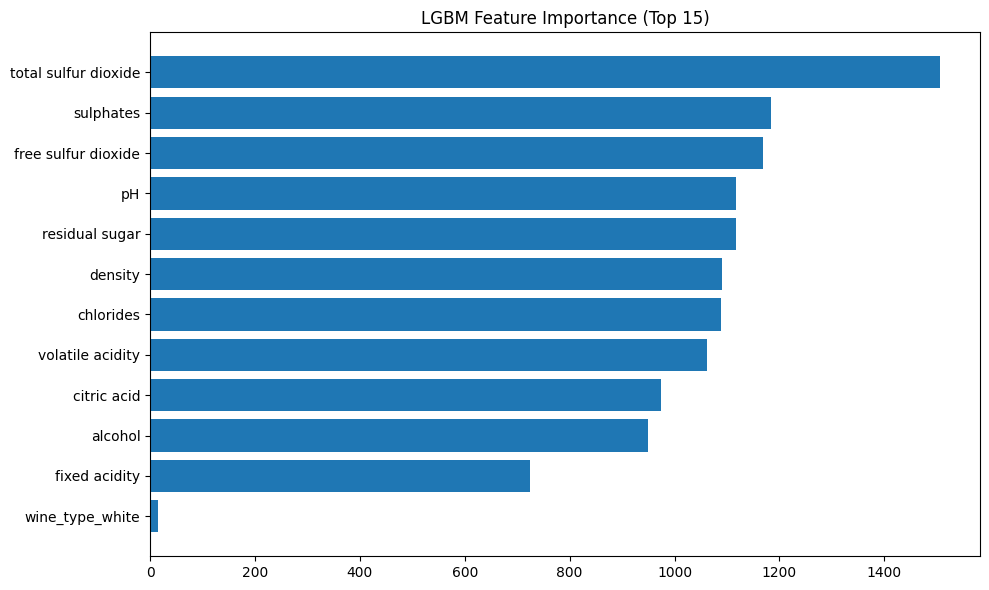

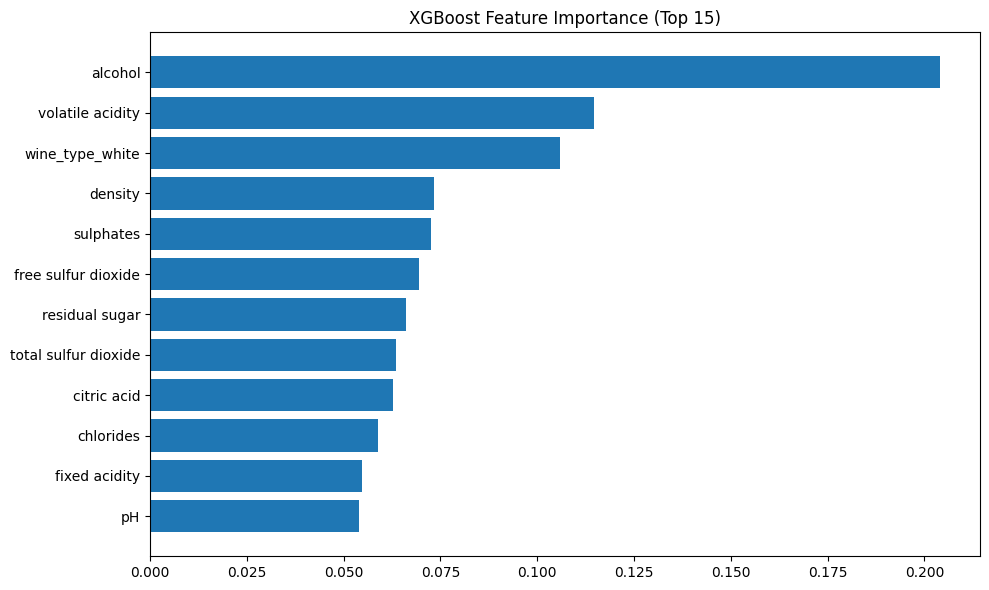

In [14]:
def get_feature_names(preprocess, X_train):
    num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    names = []
    names.extend(num_features)
    if len(cat_features) > 0:
        ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
        names.extend(ohe.get_feature_names_out(cat_features).tolist())
    return np.array(names, dtype=object)

def plot_importance(pipe, X_train, title, topk=15):
    preprocess = pipe.named_steps["preprocess"]
    clf = pipe.named_steps["clf"]
    feat_names = get_feature_names(preprocess, X_train)

    imp = getattr(clf, "feature_importances_", None)
    if imp is None:
        print("No feature_importances_")
        return

    idx = np.argsort(imp)[::-1][:topk]
    plt.figure(figsize=(10, 6))
    plt.barh(feat_names[idx][::-1], imp[idx][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()

ts = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, stratify=y, random_state=RANDOM_STATE
)

models["LGBM"].fit(X_train, y_train)
plot_importance(models["LGBM"], X_train, "LGBM Feature Importance (Top 15)")

models["XGBoost"].fit(X_train, y_train)
plot_importance(models["XGBoost"], X_train, "XGBoost Feature Importance (Top 15)")


## 14) Outliers: Boxplot AFTER IQR clipping

Outliers – Minh hoạ sau xử lý (IQR clipping)

So sánh:
- **Trước xử lý:** boxplot có nhiều điểm cực trị
- **Sau xử lý:** IQR clipping làm giảm biên độ cực trị
- Phương pháp này **không loại bỏ mẫu**, chỉ “cắt ngưỡng” để giảm ảnh hưởng outliers.
- Tránh mất dữ liệu, phù hợp khi outliers có thể là giá trị thật.


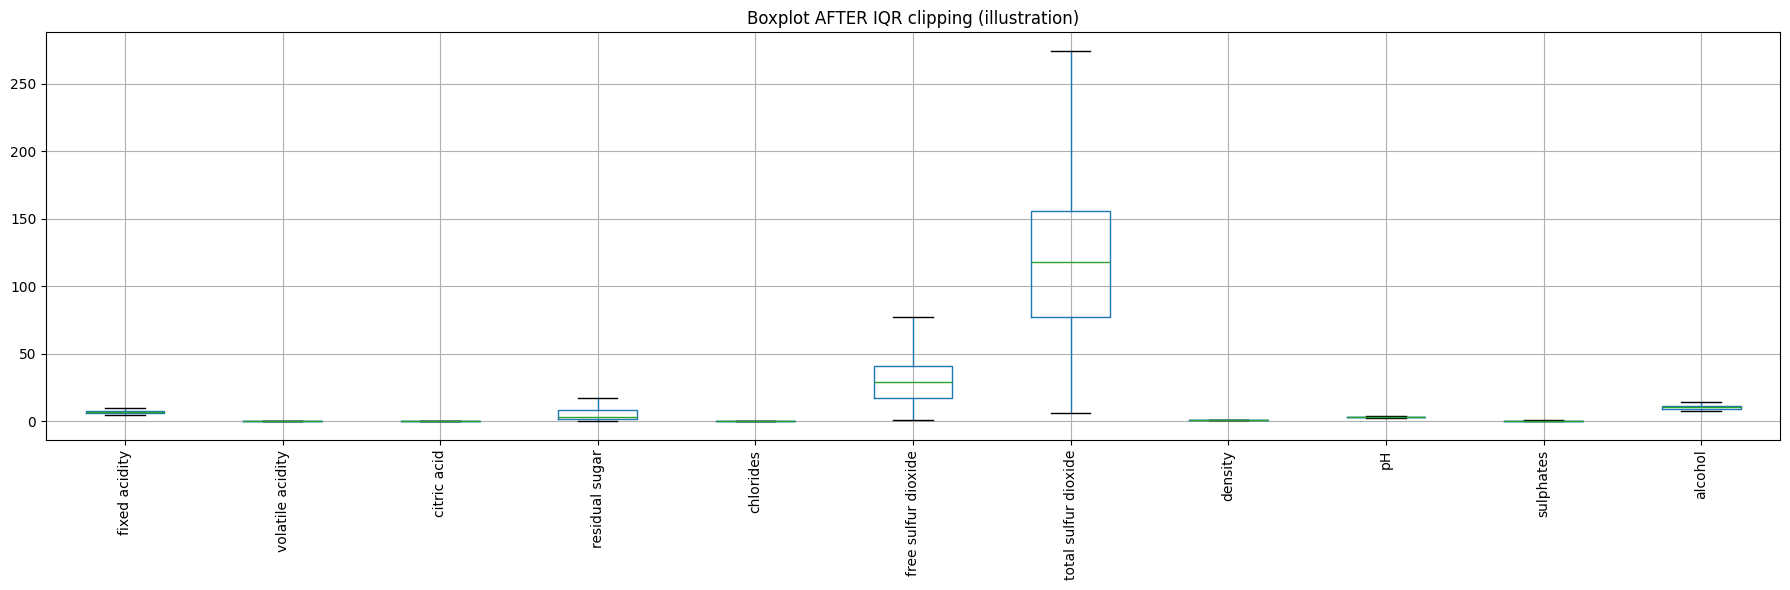

Ghi chú: IQR clipping giảm ảnh hưởng outliers, KHÔNG loại bỏ mẫu.


In [22]:
iqr = IQRClipper(factor=IQR_FACTOR)
X_num = df[feature_cols].to_numpy(dtype=float)
X_clip = iqr.fit_transform(X_num)
df_clip = pd.DataFrame(X_clip, columns=feature_cols)

plt.figure(figsize=(18, 6))
df_clip.boxplot(rot=90)
plt.title("Boxplot AFTER IQR clipping (illustration)")
plt.tight_layout()
plt.show()

print("Ghi chú: IQR clipping giảm ảnh hưởng outliers, KHÔNG loại bỏ mẫu.")


## OPTIONAL 1: So sánh Red vs White (train riêng)


 So sánh hiệu suất giữa Wine đỏ và Wine trắng

Mục tiêu:
- Huấn luyện mô hình riêng trên từng subset (red/white).
- So sánh AUC/F1 để xem nhóm nào “dễ phân loại” hơn.
- Nhận xét nguyên nhân (kích thước dữ liệu khác nhau, phân bố feature khác nhau…).
- Khi train riêng một nhóm, biến `wine_type` có thể bỏ để tránh cột hằng.


In [23]:
def holdout_compare(df_sub, test_size=0.2, drop_wine_type=True):
    y_sub = (df_sub["quality"] >= LABEL_THRESHOLD).astype(int)
    X_sub = df_sub.drop(columns=["quality"], errors="ignore").copy()
    if drop_wine_type:
        X_sub = X_sub.drop(columns=["wine_type"], errors="ignore")

    preprocess = make_preprocess(X_sub)
    models_sub = build_models(preprocess)

    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_sub, test_size=test_size, stratify=y_sub, random_state=RANDOM_STATE
    )

    out = []
    for mname, model in models_sub.items():
        r = evaluate_one(mname, model, X_train, X_test, y_train, y_test, plot=False)
        r["test_size"] = test_size
        out.append(r)
    return pd.DataFrame(out).sort_values("auc", ascending=False)

red_only = df[df["wine_type"]=="red"].copy()
white_only = df[df["wine_type"]=="white"].copy()

red_res = holdout_compare(red_only, test_size=0.2)
white_res = holdout_compare(white_only, test_size=0.2)

print("RED:")
display(red_res)
print("WHITE:")
display(white_res)

red_res["wine_type"]="red"
white_res["wine_type"]="white"
display(pd.concat([red_res, white_res], ignore_index=True).sort_values(["wine_type","auc"], ascending=[True,False]))


[LightGBM] [Info] Number of positive: 684, number of negative: 595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534793 -> initscore=0.139397
[LightGBM] [Info] Start training from score 0.139397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2606, number of negative: 1312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665135 -> initscore=0.686264
[LightGBM] [Info] Start training from score 0.686264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


RED:


,model,acc,prec,rec,f1,auc,test_size
0,LogReg,1.0,1.0,1.0,1.0,1.0,0.2
1,DecisionTree,1.0,1.0,1.0,1.0,1.0,0.2
2,LGBM,1.0,1.0,1.0,1.0,1.0,0.2
3,XGBoost,1.0,1.0,1.0,1.0,1.0,0.2


WHITE:


,model,acc,prec,rec,f1,auc,test_size
0,LogReg,1.0,1.0,1.0,1.0,1.0,0.2
1,DecisionTree,1.0,1.0,1.0,1.0,1.0,0.2
3,XGBoost,1.0,1.0,1.0,1.0,1.0,0.2
2,LGBM,1.0,1.0,1.0,1.0,1.0,0.2


,model,acc,prec,rec,f1,auc,test_size,wine_type
0,LogReg,1.0,1.0,1.0,1.0,1.0,0.2,red
1,DecisionTree,1.0,1.0,1.0,1.0,1.0,0.2,red
2,LGBM,1.0,1.0,1.0,1.0,1.0,0.2,red
3,XGBoost,1.0,1.0,1.0,1.0,1.0,0.2,red
4,LogReg,1.0,1.0,1.0,1.0,1.0,0.2,white
5,DecisionTree,1.0,1.0,1.0,1.0,1.0,0.2,white
6,XGBoost,1.0,1.0,1.0,1.0,1.0,0.2,white
7,LGBM,1.0,1.0,1.0,1.0,1.0,0.2,white


## OPTIONAL 2: Regression dự đoán quality (RMSE/MAE/R2)


 Dự đoán quality dạng số

Thay vì nhị phân hoá, ta dự đoán trực tiếp điểm `quality`.

Chỉ số đánh giá:
- **RMSE**: sai số bình phương trung bình căn bậc hai
- **MAE**: sai số tuyệt đối trung bình
- **R²**: mức độ giải thích của mô hình
- Regression thường khó hơn classification nhị phân vì cần dự đoán chính xác nhiều mức điểm.


In [24]:
def regression_run(df_all, test_size=0.2):
    y_reg = df_all["quality"].astype(float)
    X_reg = df_all.drop(columns=["quality","label"], errors="ignore").copy()

    preprocess = make_preprocess(X_reg)
    reg = Pipeline([
        ("preprocess", preprocess),
        ("reg", RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X_reg, y_reg, test_size=test_size, random_state=RANDOM_STATE
    )

    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)

    rmse = mean_squared_error(y_test, pred) ** 0.5
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return {"test_size": test_size, "rmse": rmse, "mae": mae, "r2": r2}

reg_df = pd.DataFrame([regression_run(df, ts) for ts in TEST_SIZES])
display(reg_df)


,test_size,rmse,mae,r2
0,0.1,0.586694,0.417881,0.520577
1,0.2,0.609186,0.437156,0.497516
2,0.3,0.603993,0.436437,0.500017


## OPTIONAL 3: Cross-Validation ROC-AUC (mean±std)


 Cross-Validation (Stratified K-Fold)

Mục tiêu:
- Đánh giá mô hình **ổn định** hơn so với 1 lần train/test split.
- Báo cáo ROC-AUC dưới dạng **mean ± std**.

Dùng StratifiedKFold để:
- giữ tỉ lệ lớp ở mỗi fold,
- phù hợp bài toán có class imbalance.


In [25]:
def cv_auc_models(df_all, n_splits=5):
    y_cv = (df_all["quality"] >= LABEL_THRESHOLD).astype(int)
    X_cv = df_all.drop(columns=["quality","label"], errors="ignore").copy()

    preprocess = make_preprocess(X_cv)
    models_cv = build_models(preprocess)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    rows = []
    for mname, pipe in models_cv.items():
        scores = cross_val_score(pipe, X_cv, y_cv, scoring="roc_auc", cv=skf, n_jobs=-1)
        rows.append({
            "model": mname,
            "folds": n_splits,
            "mean_auc": scores.mean(),
            "std_auc": scores.std(),
            "min_auc": scores.min(),
            "max_auc": scores.max()
        })
    return pd.DataFrame(rows).sort_values("mean_auc", ascending=False)

cv_df = cv_auc_models(df, n_splits=CV_FOLDS)
display(cv_df)


,model,folds,mean_auc,std_auc,min_auc,max_auc
2,LGBM,5,0.882972,0.003537,0.877393,0.887282
3,XGBoost,5,0.875911,0.003744,0.871116,0.881578
0,LogReg,5,0.804908,0.003714,0.798959,0.809257
1,DecisionTree,5,0.757664,0.009206,0.744621,0.770203


## OPTIONAL 4: Hyperparameter tuning (RandomizedSearchCV) cho LGBM


 Hyperparameter Tuning (RandomizedSearchCV)

Mục tiêu:
- Tối ưu siêu tham số cho mô hình boosting (ví dụ LGBM).
- Tìm cấu hình tốt hơn so với mặc định.

RandomizedSearchCV được dùng vì:
- nhanh hơn GridSearch khi không gian tham số lớn,
- vẫn cho kết quả tốt trong thời gian hợp lý.


In [26]:
from lightgbm import LGBMClassifier

y_tune = (df["quality"] >= LABEL_THRESHOLD).astype(int)
X_tune = df.drop(columns=["quality","label"], errors="ignore").copy()

preprocess = make_preprocess(X_tune)

pipe_lgbm = Pipeline([
    ("preprocess", preprocess),
    ("clf", LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True))
])

param_dist = {
    "clf__n_estimators": [200, 400, 800],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_depth": [-1, 4, 6, 8],
    "clf__num_leaves": [15, 31, 63, 127],
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
}

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

rs = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=skf,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_tune, y_tune)
print("Best AUC:", rs.best_score_)
print("Best params:", rs.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 4113, number of negative: 2384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 6497, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633061 -> initscore=0.545373
[LightGBM] [Info] Start training from score 0.545373
Best AUC: 0.9017221940793408
Best params: {'clf__subsample': 0.85, 'clf__num_leaves': 127, 'clf__n_estimators': 400, 'clf__max_depth': -1, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.85}


 15) Kết luận & Hướng phát triển

## Kết luận
- Mô hình tốt nhất (theo AUC/F1) thường là **LightGBM hoặc XGBoost** do khả năng học quan hệ phi tuyến.
- Các đặc trưng thường quan trọng: `alcohol`, `volatile acidity`, `sulphates`, `density`, `total sulfur dioxide` (tuỳ kết quả).
- IQR clipping giúp giảm ảnh hưởng outliers mà vẫn giữ dữ liệu.

## Hướng phát triển
- Tuning sâu hơn + báo cáo CV mean±std đầy đủ.
- Dùng SHAP để giải thích mô hình.
- Thử thêm regression nâng cao (LGBMRegressor/XGBRegressor).
- Đóng gói mô hình và triển khai demo dự đoán.
